In [1]:
# Ensure relevant packages are installed
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install biopython
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow

In [2]:
from Bio import SeqIO

#Ex.1: read file, one hot encode, decode; use an example

#Step 1: read file - sequence + functionality
#Create dictionary: keys = sequence_n; values = prot sequence, functionality
file = "./MSA_nat_with_annotation.faa"

data_dict = {}
for seq_record in SeqIO.parse(file, "fasta"):
    data_dict[seq_record.id] = seq_record.seq, seq_record.description.replace(seq_record.id+' ','',1)
    #if seq_record.description.replace(seq_record.id+' ','',1) == "functional_true":
        #label = 1
    #else:
        #label = 0
    #data_dict[seq_record.id] = seq_record.seq, label
    #print(seq_record.id)
    #print(seq_record.description.replace(seq_record.id+' ','',1))
    #print(repr(seq_record.seq))
    #print(len(seq_record))

print(data_dict.get("sequence_1")[0])
print(data_dict.get("sequence_1")[1])
print(data_dict.get("sequence_2")[0])
print(data_dict.get("sequence_2")[1])

-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGK-AHHLDAHYITRLFQLIIEDSVLTQQALLQQH
functional_true
---DERIQALRKEVDRVNREILRLLSERGRLVQEIGRLQTELGLPHYDPKREEEMLAYLTAEN--PGPFPDETIRKLFKEIFKASLDLEERQDQ--
functional_false


In [3]:
#One hot encoding
import numpy as np

# define alphabet of possible input values
alphabet ='ACDEFGHIKLMNPQRSTVWY-'

def one_hot_encoder(MSA_str, alphabet):
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in MSA_str]
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
        if value == char_to_int.get("-"):
            letter = [0 for value in range(len(alphabet)-1)]
        else:
            letter = [0 for value in range(len(alphabet)-1)]
            letter[value] = 1
        onehot_encoded.append(letter)
    return onehot_encoded

#cuz you don't set a lock without getting a key
def one_hot_decoder(encoded_str, alphabet):
    # define a mapping of integers to chars
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    decoded = ''
    for i in range(np.shape(encoded_str)[0]):
        if np.count_nonzero(encoded_str[i]) == 0:
            inverted = '-'
        else:
            inverted = int_to_char[np.argmax(encoded_str[i])]
        decoded += inverted
    return decoded

#Check that - is properly encoded 
tmp_sequence = "-"
encoded = one_hot_encoder(tmp_sequence, alphabet)
print(encoded)
decoded = one_hot_decoder(encoded, alphabet)
print(decoded)

#Example + get a reference encoded array
tmp_sequence = data_dict.get("sequence_1")[0]
encoded_ref = one_hot_encoder(tmp_sequence, alphabet)
print(np.shape(encoded))
decoded = one_hot_decoder(encoded_ref, alphabet)
print(tmp_sequence)
print(decoded)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
-
(1, 20)
-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGK-AHHLDAHYITRLFQLIIEDSVLTQQALLQQH
-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGK-AHHLDAHYITRLFQLIIEDSVLTQQALLQQH


In [4]:
#Create a single array of encoded data to apply PCA on: single one hot vector
encoded_data = np.empty([len(data_dict), np.shape(encoded_ref)[0]*np.shape(encoded_ref)[1]])
for i in range(len(data_dict)):
    sequence = data_dict.get("sequence_"+str(i+1))[0]
    encoded = one_hot_encoder(sequence, alphabet)
    concatenated = encoded[0]
    for j in range(len(encoded)-1):
        concatenated = np.concatenate((concatenated, encoded[j+1]), axis = None)
    encoded_data[i] = concatenated

print(np.shape(encoded_data))

#create array of labels: 1 if functional_true, O if functional_false
labels = np.empty(len(data_dict))
for i in range(len(data_dict)):
    if data_dict.get("sequence_"+str(i+1))[1] == "functional_true":
        labels[i]=1
    else:
        labels[i]=0
print(np.shape(labels))

encoded_artificial = encoded_data
labels_artificial = labels

(1130, 1920)
(1130,)


In [5]:
#Apply PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the features
encoded_data = StandardScaler().fit_transform(encoded_data)

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(encoded_data)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print(np.shape(principalComponents))

Explained variation per principal component: [0.01851641 0.01602757 0.01504451 0.01288505]
(1130, 4)


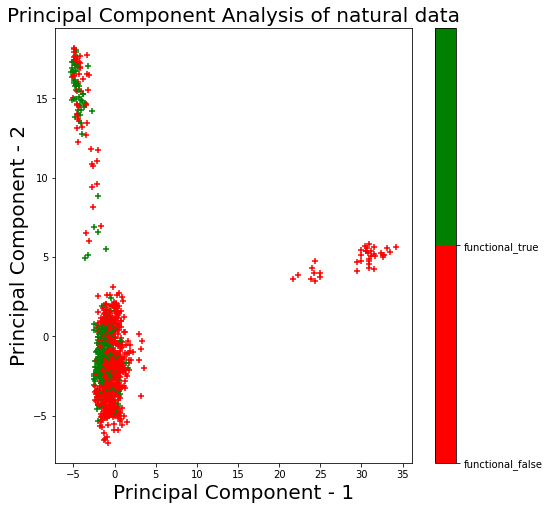

In [6]:
import matplotlib
import matplotlib.pyplot as plt

#red => 0 => functional_false; green => 1 => functional_true
colors = ['red','green']

fig = plt.figure(figsize=(8,8))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels,marker = '+', 
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of natural data",fontsize=20)

cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(["functional_false", "functional_true"])

(1003, 4)
Explained variation per principal component: [0.02776588 0.02524491 0.02456729 0.0225136 ]


Text(0.5, 1.0, 'Principal Component Analysis of natural data')

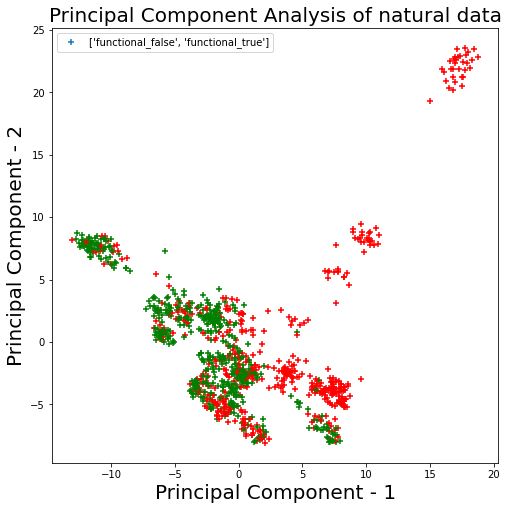

In [7]:
file = "./MSA_art.faa"
data_dict = {}
for seq_record in SeqIO.parse(file, "fasta"):
    data_dict[seq_record.id] = seq_record.seq, seq_record.description.replace(seq_record.id+' ','',1)

#Same with artificial data
encoded_data = np.empty([len(data_dict), np.shape(encoded_ref)[0]*np.shape(encoded_ref)[1]])
for i in range(len(data_dict)):
    sequence = data_dict.get("sequence_"+str(i+1))[0]
    encoded = one_hot_encoder(sequence, alphabet)
    concatenated = encoded[0]
    for j in range(len(encoded)-1):
        concatenated = np.concatenate((concatenated, encoded[j+1]), axis = None)
    encoded_data[i] = concatenated

#create array of labels: 1 if functional_true, O if functional_false
labels = np.empty(len(data_dict))
for i in range(len(data_dict)):
    if data_dict.get("sequence_"+str(i+1))[1] == "functional_true":
        labels[i]=1
    else:
        labels[i]=0
        
encoded_natural = encoded_data
labels_natural = labels

# Standardizing the features
encoded_data = StandardScaler().fit_transform(encoded_data)

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(encoded_data)
print(np.shape(principalComponents))

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#red => 0 => functional_false; green => 1 => functional_true
colors = ['red','green']
groups = ['functional_false', 'functional_true']

fig = plt.figure(figsize=(8,8))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels, marker = '+', label=groups,
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.legend(loc=2)
plt.title("Principal Component Analysis of natural data",fontsize=20)

In [8]:
#Supervised learning: use a NN
#To get better results, we are going to use all labeled data, artificial and natural

initial_data = np.concatenate((encoded_natural, encoded_artificial))
output_data = np.concatenate((labels_natural, labels_artificial))
print(np.shape(initial_data))


input_data = StandardScaler().fit_transform(initial_data)
#Want PCA with n_components such that at least 99% of the variance is kept (WIP)
pca = PCA(n_components=1400)
input_data = pca.fit_transform(initial_data)
print(np.shape(input_data))
print(np.sum(pca.explained_variance_ratio_)*100)

(2133, 1920)
(2133, 1400)
99.98305502502745


In [9]:
#Supervised learning: NN
from keras import losses, optimizers, metrics, callbacks
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dense, Add

params = {
    'compilation': {
            'optimizer': Adam(
                learning_rate=0.001
                ),
            'loss': losses.MeanSquaredError(),
            'metrics': [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()],
        },
    'fit': {
        'batch_size': 32,
        'epochs': 100,
        'callbacks' : [
            callbacks.EarlyStopping(monitor='loss', patience=7), 
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]
            }
          }

model = Sequential() 
input_layer = Dense(32, input_shape=(np.shape(input_data)[1],)) 
model.add(input_layer) 
hidden_layer = Dense(64, activation='relu')
model.add(hidden_layer)
hidden_layer = Dense(64, activation='relu')
model.add(hidden_layer) 
output_layer = Dense(1, activation="sigmoid") 
model.add(output_layer)

model.compile(**params['compilation'])

#Def fraction train/test/validation
fraction_train = 0.8
fraction_test = 0.1

stop_1 = int(fraction_train*len(output_data))
stop_2 = stop_1 + int(fraction_test*len(output_data))

X_train, y_train = input_data[:stop_1], output_data[:stop_1]
X_test, y_test = input_data[stop_1+1:stop_2], output_data[stop_1+1:stop_2]
X_validation, y_validation = input_data[stop_2+1:], output_data[stop_2+1:]

print('Training network (this might take a while)...')
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    verbose=0,
    **params['fit']
)

print('Number of epochs run:', len(history.history['loss']))

# Calculate and print scores
print('Evaluating model performance on test set...')
scores = model.evaluate(X_test, y_test, verbose=0)

max_metrics_name_length = len(max(model.metrics_names, key=len))
print()
print(' Scores '.center(max_metrics_name_length + 13, '='))
line = '{:<%i} : {:.4e}' % max_metrics_name_length
for i in range(len(model.metrics_names)):
    print(line.format(model.metrics_names[i], scores[i]))
print()

Training network (this might take a while)...
Number of epochs run: 77
Evaluating model performance on test set...

============ Scores ============
loss                : 2.9520e-01
mean_squared_error  : 2.9520e-01
mean_absolute_error : 3.4931e-01



In [10]:
#Now for the fun part: load the unlabeled data, preprocess it and label it
file = "./MSA_nat_no_annotation.faa"
#dictionary key = name, value = prot sequence
data_dict = {}
index=1
for seq_record in SeqIO.parse(file, "fasta"):
    data_dict['sequence_' + str(index)] = seq_record.seq
    index += 1

encoded_ref = one_hot_encoder(data_dict.get("sequence_1"), alphabet)

encoded_data = np.empty([len(data_dict), np.shape(encoded_ref)[0]*np.shape(encoded_ref)[1]])
number_of_corrupted_lines = 0
corrupted_indexes = []
for i in range(len(data_dict)):
    sequence = data_dict.get("sequence_"+str(i+1))
    #Some Xs are hanging around in the files, need to avoid them
    try:
        encoded = one_hot_encoder(sequence, alphabet)
        concatenated = encoded[0]
        for j in range(len(encoded)-1):
            concatenated = np.concatenate((concatenated, encoded[j+1]), axis = None)
        encoded_data[i] = concatenated
    except:
        corrupted_indexes.append(i)
        number_of_corrupted_lines += 1

print(np.shape(encoded_data))

for i in range(len(corrupted_indexes)):
    encoded_data = np.delete(encoded_data, i, axis = 0)
        
print(number_of_corrupted_lines)
print(np.shape(encoded_data))

encoded_data = StandardScaler().fit_transform(encoded_data)
pca = PCA(n_components=1400)
input_data = pca.fit_transform(encoded_data)
print(np.sum(pca.explained_variance_ratio_)*100)

(6311, 1920)
42
(6269, 1920)
99.94727105657292


(6269, 1400)
(6269, 1)


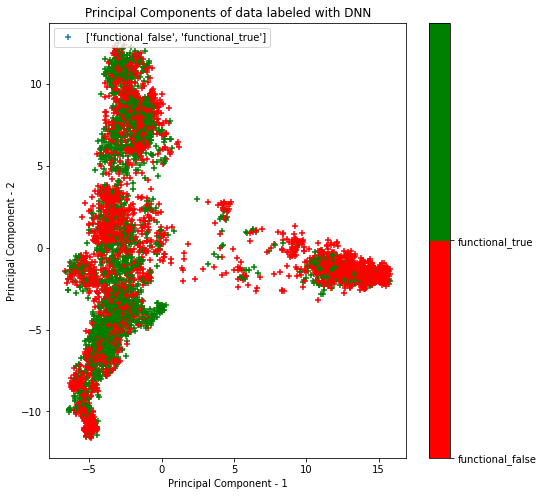

In [11]:
print(np.shape(input_data))
pred_labels = model.predict(input_data)

print(np.shape(pred_labels))

#red => 0 => functional_false; green => 1 => functional_true
colors = ['red','green']
groups = ['functional_false', 'functional_true']

fig = plt.figure(figsize=(8,8))
plt.scatter(input_data[:,0], input_data[:,1], c=pred_labels, marker = '+', label=groups,
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.legend(loc=2)
plt.title("Principal Components of data labeled with DNN")

cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(["functional_false", "functional_true"])

In [12]:
print(pred_labels)

[[5.6579283e-06]
 [1.0000000e+00]
 [8.4635820e-23]
 ...
 [3.0801134e-06]
 [1.0000000e+00]
 [2.0054162e-20]]
